<a href="https://colab.research.google.com/github/comchem/Pytorch_DeepLearning_Tutorials/blob/master/Sec6-RNN_%26_TimeSeries/8-Stock_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Part 1: Price Prediction

In [2]:
!git clone https://github.com/comchem/machine_learning_examples.git

Cloning into 'machine_learning_examples'...
remote: Enumerating objects: 2058, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 2058 (delta 10), reused 14 (delta 6), pack-reused 2034
Receiving objects: 100% (2058/2058), 21.98 MiB | 35.84 MiB/s, done.
Resolving deltas: 100% (970/970), done.


In [3]:
# yes, you can read dataframes from URLs
path = './machine_learning_examples/pytorch/sbux.csv'
df = pd.read_csv(path)

In [4]:
df.tail()

,AAPL,MSI,SBUX
1254,167.78,99.12,56.00
1255,160.50,103.87,55.77
1256,156.49,101.06,54.69
1257,163.03,102.76,55.61
1258,159.54,102.63,54.46


In [5]:
# Start by doing the wrong thing - trying to predict the price itself
series = df['SBUX'].values.reshape(-1,1)

In [6]:
# Normalize the data
# Note: I didn't think about when the true boundary is, this is just approx.
scalar = StandardScaler()
scalar.fit(series[:len(series) // 2])   # 2D array로 fit 한 이후에 flatten하여 다시 1D로 전환
series = scalar.transform(series).flatten()

In [7]:
series

array([-1.62500489, -1.64174953, -1.6330132 , ...,  2.2342704 ,
        2.36822751,  2.20078112])

In [8]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T, 1)   # Reshape N x T x D : 3 dimensions
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249, 1)


In [9]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
### Define RNN
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.LSTM(
          input_size = self.D,
          hidden_size = self.M,
          num_layers = self.L,
          batch_first = True)
    
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, (h0, c0))
        
        # we only want h(T) at the final time step
        # N x M --> N x K
        out = self.fc(out[:, -1, :])
        return out

In [11]:
# Instantiate the model
model = RNN(n_inputs = 1, n_hidden=5, n_rnnlayers = 1, n_outputs = 1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)

In [13]:
# Make inputs and targets
X_train = torch.from_numpy(X[:N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32))
X_test = torch.from_numpy(X[N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[N//2:].astype(np.float32))

In [14]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [15]:
# Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs = 200):
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Save losses
        train_losses[it] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it+1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss:  {test_loss.item():.4f}')
    
    return train_losses, test_losses

In [16]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch 5/200, Train Loss: 0.2976, Test Loss:  1.6285
Epoch 10/200, Train Loss: 0.1107, Test Loss:  0.3391
Epoch 15/200, Train Loss: 0.0630, Test Loss:  0.2594
Epoch 20/200, Train Loss: 0.0288, Test Loss:  0.1274
Epoch 25/200, Train Loss: 0.0137, Test Loss:  0.1487
Epoch 30/200, Train Loss: 0.0169, Test Loss:  0.1713
Epoch 35/200, Train Loss: 0.0122, Test Loss:  0.1329
Epoch 40/200, Train Loss: 0.0085, Test Loss:  0.1239
Epoch 45/200, Train Loss: 0.0069, Test Loss:  0.1002
Epoch 50/200, Train Loss: 0.0071, Test Loss:  0.0856
Epoch 55/200, Train Loss: 0.0067, Test Loss:  0.0706
Epoch 60/200, Train Loss: 0.0061, Test Loss:  0.0660
Epoch 65/200, Train Loss: 0.0057, Test Loss:  0.0624
Epoch 70/200, Train Loss: 0.0056, Test Loss:  0.0595
Epoch 75/200, Train Loss: 0.0055, Test Loss:  0.0520
Epoch 80/200, Train Loss: 0.0054, Test Loss:  0.0507
Epoch 85/200, Train Loss: 0.0053, Test Loss:  0.0506
Epoch 90/200, Train Loss: 0.0053, Test Loss:  0.0526
Epoch 95/200, Train Loss: 0.0053, Test Loss:  0

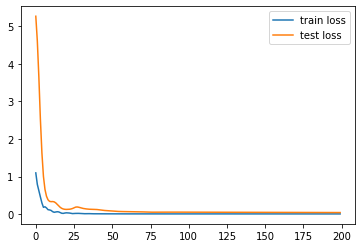

In [17]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [18]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly

validation_target = Y[N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(1,T,1)
    p = model(input_)[0,0].item()     # 각 row에 따라 나누어 prediction 하기 때문에 [0,0] item으로 값을 받음 -> scalar
    i += 1
    
    # update the predictions list
    validation_predictions.append(p)

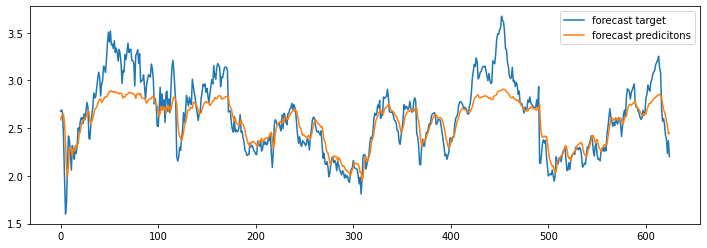

In [19]:
plt.figure(figsize=(12,4))
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predicitons')
plt.legend()
plt.show()

In [20]:
# Multi-step forecast future values (use only self-predictions for making future predictions)

validation_target = Y[N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1,T,1)
    p = model(input_)
    
    # update the predictions list
    validation_predictions.append(p[0,0].item())
    
    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))   # last_x에서 9개만 선택 후 p[0]의 prediction 값 1개를 row로 추가하여 last_x에 다시 저장
    # cat은 row bind 혹은 col bind와 같은 역할을 함 : torch.cat((x,x,x), 0) -> row, torch.cat((x,x,x),1) -> col

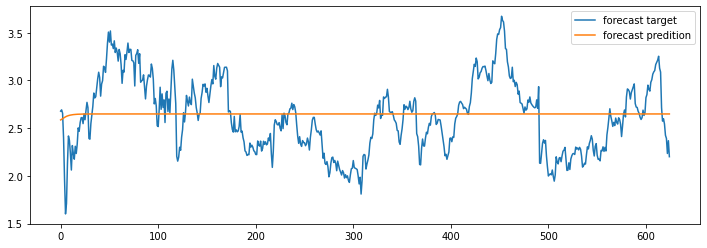

In [21]:
plt.figure(figsize=(12,4))
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predition')
plt.legend()
plt.show()

# Part 2: Returns

In [22]:
# calculate returns by first shifting the data
df['PrevSBUX'] = df['SBUX'].shift(1)  # move everythig up 1

# SBUX / Prev SBUX
# x[2]   x[1]
# x[2]   x[1]
# x[2]   x[1]
# ...
# x[t]   x[t-1]

In [23]:
df.head()

,AAPL,MSI,SBUX,PrevSBUX
0,67.8542,60.30,28.185,NaN
1,68.5614,60.90,28.070,28.185
2,66.8428,60.83,28.130,28.070
3,66.7156,60.81,27.915,28.130
4,66.6556,61.12,27.775,27.915


In [24]:
# Return calculation
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['SBUX'] - df['PrevSBUX']) / df['PrevSBUX']

In [25]:
df.head()

,AAPL,MSI,SBUX,PrevSBUX,Return
0,67.8542,60.30,28.185,NaN,NaN
1,68.5614,60.90,28.070,28.185,-0.004080
2,66.8428,60.83,28.130,28.070,0.002138
3,66.7156,60.81,27.915,28.130,-0.007643
4,66.6556,61.12,27.775,27.915,-0.005015


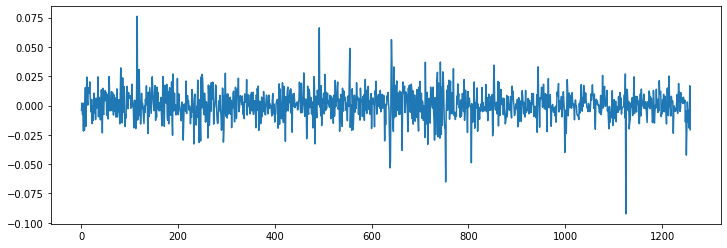

In [26]:
plt.figure(figsize=(12,4))
plt.plot(df['Return'])
plt.show()

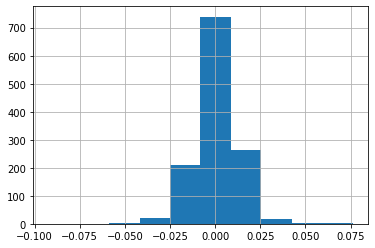

In [27]:
# Now let's try an LSTM to predict returns
df['Return'].hist()
plt.show()

In [28]:
series = df['Return'].values[1:].reshape(-1,1)

# Normalize the data
# Note: I didn't think about when the true boundary is, this is just approx.
scalar = StandardScaler()
scalar.fit(series[:len(series) // 2])   # 2D array로 fit 한 이후에 flatten하여 다시 1D로 전환
series = scalar.transform(series).flatten()

In [29]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T, 1)   # Reshape N x T x D : 3 dimensions
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1238, 20, 1) Y.shape (1238, 1)


In [30]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
### Define RNN
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.LSTM(
          input_size = self.D,
          hidden_size = self.M,
          num_layers = self.L,
          batch_first = True)
    
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, (h0, c0))
        
        # we only want h(T) at the final time step
        # N x M --> N x K
        out = self.fc(out[:, -1, :])
        return out

In [32]:
# Instantiate the model
model = RNN(n_inputs = 1, n_hidden=5, n_rnnlayers = 1, n_outputs = 1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [33]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)

In [34]:
# Make inputs and targets
X_train = torch.from_numpy(X[:N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32))
X_test = torch.from_numpy(X[N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[N//2:].astype(np.float32))

In [35]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [36]:
# Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs = 200):
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Save losses
        train_losses[it] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it+1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss:  {test_loss.item():.4f}')
    
    return train_losses, test_losses

In [37]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch 5/200, Train Loss: 1.0588, Test Loss:  1.0870
Epoch 10/200, Train Loss: 1.0515, Test Loss:  1.0663
Epoch 15/200, Train Loss: 1.0446, Test Loss:  1.0798
Epoch 20/200, Train Loss: 1.0391, Test Loss:  1.0751
Epoch 25/200, Train Loss: 1.0326, Test Loss:  1.0921
Epoch 30/200, Train Loss: 1.0255, Test Loss:  1.0936
Epoch 35/200, Train Loss: 1.0184, Test Loss:  1.1061
Epoch 40/200, Train Loss: 1.0107, Test Loss:  1.1109
Epoch 45/200, Train Loss: 1.0030, Test Loss:  1.1195
Epoch 50/200, Train Loss: 0.9951, Test Loss:  1.1313
Epoch 55/200, Train Loss: 0.9865, Test Loss:  1.1392
Epoch 60/200, Train Loss: 0.9766, Test Loss:  1.1559
Epoch 65/200, Train Loss: 0.9649, Test Loss:  1.1779
Epoch 70/200, Train Loss: 0.9534, Test Loss:  1.2003
Epoch 75/200, Train Loss: 0.9397, Test Loss:  1.2115
Epoch 80/200, Train Loss: 0.9214, Test Loss:  1.2352
Epoch 85/200, Train Loss: 0.9125, Test Loss:  1.2671
Epoch 90/200, Train Loss: 0.8971, Test Loss:  1.2683
Epoch 95/200, Train Loss: 0.8825, Test Loss:  1

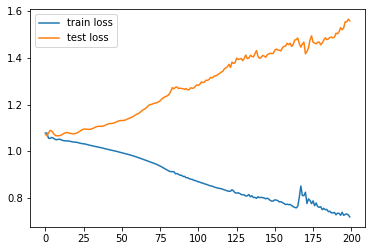

In [38]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [39]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly

validation_target = Y[N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(1,T,1)
    p = model(input_)[0,0].item()     # 각 row에 따라 나누어 prediction 하기 때문에 [0,0] item으로 값을 받음 -> scalar
    i += 1
    
    # update the predictions list
    validation_predictions.append(p)

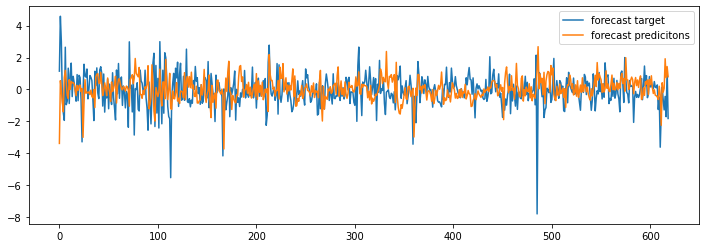

In [40]:
plt.figure(figsize=(12,4))
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predicitons')
plt.legend()
plt.show()

In [41]:
# Multi-step forecast future values (use only self-predictions for making future predictions)

validation_target = Y[N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1,T,1)
    p = model(input_)
    
    # update the predictions list
    validation_predictions.append(p[0,0].item())
    
    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))   # last_x에서 9개만 선택 후 p[0]의 prediction 값 1개를 row로 추가하여 last_x에 다시 저장
    # cat은 row bind 혹은 col bind와 같은 역할을 함 : torch.cat((x,x,x), 0) -> row, torch.cat((x,x,x),1) -> col

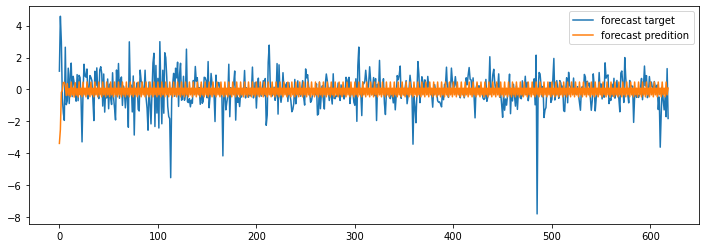

In [42]:
plt.figure(figsize=(12,4))
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predition')
plt.legend()
plt.show()

# Part 3: Binary Classification

In [88]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!   
input_data = df[['AAPL', 'MSI', 'SBUX']].values     # pandas df to numpy array
targets = df['Return'].values

In [89]:
input_data

array([[ 67.8542,  60.3   ,  28.185 ],
       [ 68.5614,  60.9   ,  28.07  ],
       [ 66.8428,  60.83  ,  28.13  ],
       ...,
       [156.49  , 101.06  ,  54.69  ],
       [163.03  , 102.76  ,  55.61  ],
       [159.54  , 102.63  ,  54.46  ]])

In [90]:
# Now make the actural data which will go into the neural network
T = 10
D = input_data.shape[1]    # Dimension is # features = 3
N = len(input_data) - T

In [91]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3    # 2/3 train data 갯수
scalar = StandardScaler()            # array를 StandardScaler로 다룬다.
scalar.fit(input_data[:Ntrain + T -1])
input_data = scalar.transform(input_data)

In [92]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [93]:
X_train.shape

(839, 10, 3)

In [94]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):
  # u counts from 0 ... (N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain 
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [95]:
# make the RNN
model = RNN(5, 50, 2, 1)
model.to(device)

RNN(
  (rnn): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [96]:
# Loss and optimizer - it's classification now!
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [97]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

In [98]:
# move data to CPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [100]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs = 300)

RuntimeError: ignored